In [1]:
import numpy as np
import matplotlib.pyplot as plt
import typing
import time

from numba import njit, prange, objmode

In [16]:
Ly = 4
Lx_arr = np.arange(2, 9, 1).astype(int)
kT_arr = np.arange(1, 5, 0.1)
correct_answer_Lx_4 = [-1.99715844, -1.99396091, -1.98856632, -1.98016965, -1.96786355, -1.95064256,
                     -1.9274244,  -1.89711215, -1.85871667, -1.81153907, -1.75538029, -1.69071311,
                     -1.61874282, -1.54131149, -1.46065977, -1.37911648, -1.29880759, -1.22145424,
                     -1.14828469, -1.0800446,  -1.01706963, -0.95938399, -0.90679838, -0.85899291,
                     -0.8155803,  -0.77615005, -0.74029707, -0.70763857, -0.67782287, -0.65053286,
                     -0.62548613, -0.60243323, -0.58115501, -0.56145948, -0.5431787,  -0.52616582,
                     -0.5102923,  -0.49544555, -0.48152673, -0.46844889]
correct_answer_Lx_5 = [-1.99715893, -1.99396296, -1.98857263, -1.98018387, -1.96788363, -1.95063964,
                     -1.92729692, -1.89661121, -1.85735639, -1.80853133, -1.74965024, -1.68103752,
                     -1.60399878, -1.52075577, -1.43412763, -1.3470633,  -1.26219309, -1.18153361,
                     -1.10638872, -1.03740747, -0.97472647, -0.918132,   -0.86720255, -0.82141645,
                     -0.78022445, -0.74309384, -0.70953215, -0.67909749, -0.65140075, -0.62610332,
                     -0.60291264, -0.58157686, -0.56187952, -0.54363452, -0.52668165, -0.51088271,
                     -0.49611811, -0.48228409, -0.46929029, -0.45705774,]

In [3]:
@njit(parallel=True, fastmath=True)
def izing_model(Lx: np.int8, Ly : np.int8, kT_arr: np.ndarray):
    '''
    Функция расчитывает нормализованное значение средней энергии для решетки молекул размера Lx*Ly и 
    температур из массива kT_arr согласно модели Изинга.
    Input:
    Lx - размер решетки по x
    Ly - размер решетки по y
    kT_arr - массив Numpy температур на константу Больцмана
    Output:
    Одномерный массив нумпай со значениями нормализованной средней энергии для каждой kT.
    '''
    normalized_average_energies = np.empty(len(kT_arr), dtype = np.float32)
    N = Lx * Ly
    for T_i in prange(len(kT_arr)):
        
        E_arr = np.zeros(2**N)
        Z_arr = np.zeros(2**N)
        for s in range(2**N):
            E = 0
            J = 1
            spins = np.full(N, -1, dtype=np.int8)
            i = N-1
            s_copy = s
            while s_copy > 0:
                remainder = s_copy % 2
                if remainder == 1:      
                    spins[i] = remainder
                s_copy = s_copy // 2
                i = i - 1
            spins = spins.reshape(Lx, Ly)
            for i in range(-1, Lx-1):
                for j in range(-1, Ly-1):
                    E -= J * spins[i, j] * (spins[i + 1, j] + spins[i, j + 1])
            Z = np.exp(- E / kT_arr[T_i])
            Z_arr[s] = Z
            E_arr[s] = E
        normalized_average_energies[T_i] = np.sum(E_arr*Z_arr)* (1/(Lx*Ly*np.sum(Z_arr)))
    return normalized_average_energies

In [4]:
Lx = 4
print(np.round(izing_model(Lx, Ly, kT_arr) - correct_answer_Lx_4, 5))

[ 0.  0.  0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0. -0.
  0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0.  0.  0. -0.  0. -0.
  0.  0. -0.  0.]


In [5]:
Lx = 5
np.round(izing_model(Lx, Ly, kT_arr) - correct_answer_Lx_5, 5)

array([ 0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,
        0., -0., -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,
        0.,  0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,
       -0.])

In [6]:
@njit(parallel=True, fastmath=True)
def izing_model_with_different_Lx(Lx_arr : np.ndarray, Ly : np.int8, kT_arr : np.ndarray):
    '''
    Функция расчитывает нормализованное значение средней энергии для решетки молекул размера Lx*Ly
    (для всех Lx из массива Lx_arr) и температур из массива kT_arr согласно модели Изинга.
    Input:
    Lx_arr - массив Numpy размеров решетки по x
    Ly - размер решетки по y
    kT_arr - массив Numpy температур на константу Больцмана
    Output:
    Двумерный массив нумпай со значениями нормализованной средней энергии <E> для каждой kT и каждого Lx. 
    То есть возвращаемое_значение[i, j] равно значению <E> при размере решетки Lx[j]*Ly и k*температуру kT[i].
    '''
    J = 1
    normalized_average_energies = np.empty((len(kT_arr), len(Lx_arr)), dtype = np.float64)
    #for Lx_i, Lx in enumerate(Lx_arr):
    for Lx_i in range(len(Lx_arr)):
        with objmode(start='f8'):
            start = time.time()
        Lx = Lx_arr[Lx_i]
        N = Lx * Ly
        arr = np.arange(N)
        for kT_i in range(len(kT_arr)):
            E_arr = np.zeros(2**N, dtype=np.int32)
            Z_arr = np.zeros(2**N, dtype=np.float32)
            for s in prange(2**N):
                E = 0
                spins = (((s >> arr) & 1) * 2 - 1).reshape(Lx, Ly)
                for i in range(-1, Lx-1):
                    for j in range(-1, Ly-1):
                        E -= J * spins[i, j] * (spins[i + 1, j] + spins[i, j + 1])
                Z = np.exp(- E / kT_arr[kT_i])
                Z_arr[s] = Z
                E_arr[s] = E
            normalized_average_energies[kT_i, Lx_i] = np.sum(E_arr*Z_arr)* (1/(N*np.sum(Z_arr)))
        with objmode():
            end = time.time()
            print(f'Время расчета для Lx = {Lx}: {end - start}')
    return normalized_average_energies

In [7]:
result = izing_model_with_different_Lx(Lx_arr, Ly, kT_arr)

Время расчета для Lx = 2: 0.004004001617431641
Время расчета для Lx = 3: 0.003002166748046875
Время расчета для Lx = 4: 0.028024911880493164
Время расчета для Lx = 5: 0.5825304985046387
Время расчета для Lx = 6: 7.728032350540161
Время расчета для Lx = 7: 129.95385122299194
Время расчета для Lx = 8: 4070.9917047023773


In [8]:
np.save('result.npy', result)

In [19]:
energy = np.load('result.npy')
print('Нормированное значение средней энергии при температурах  kT∈[1.0,5.0) :')
for i in range(len(Lx_arr)):
    print('Lx = ', Lx_arr[i])
    print(energy[:, i])

Нормированное значение средней энергии при температурах  kT∈[1.0,5.0) :
Lx =  2
[-1.9950943  -1.98967853 -1.9807484  -1.96731099 -1.94851495 -1.92375805
 -1.89277291 -1.85565666 -1.81286305 -1.76514811 -1.71347571 -1.65892234
 -1.60257403 -1.54544916 -1.48844218 -1.43229534 -1.37758951 -1.32475208
 -1.27407531 -1.22573604 -1.17982009 -1.13634292 -1.09526762 -1.056521
 -1.0200058  -0.98560873 -0.95321074 -0.92268863 -0.89392041 -0.86678829
 -0.84117929 -0.81698626 -0.7941092  -0.77245493 -0.75193627 -0.73247317
 -0.71399178 -0.69642346 -0.67970555 -0.66378015]
Lx =  3
[-1.99711773 -1.99383632 -1.98825232 -1.97949377 -1.96659168 -1.94853232
 -1.92432621 -1.8931225  -1.85433615 -1.80777815 -1.75375213 -1.69305918
 -1.62695636 -1.55700056 -1.48487848 -1.41223048 -1.34050987 -1.27089462
 -1.20425894 -1.14118326 -1.08199266 -1.02680918 -0.97560146 -0.92823304
 -0.88450073 -0.84416301 -0.80696154 -0.77263706 -0.74093833 -0.71162685
 -0.68448227 -0.65930217 -0.63590254 -0.61411704 -0.59379589 

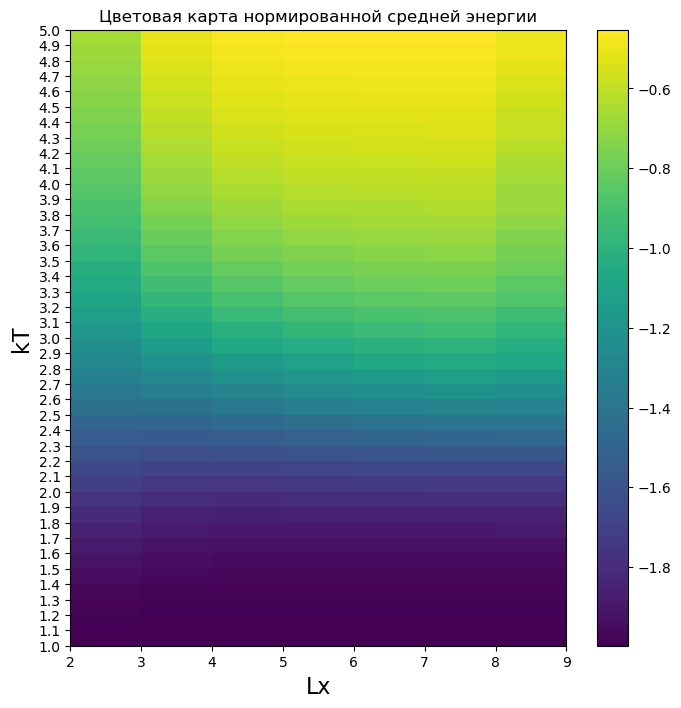

In [22]:
Lx_arr = np.arange(2, 10, 1).astype(int)
kT_arr = np.arange(1, 5.1, 0.1)

#energy = np.transpose(energy)
plt.figure(figsize=(8, 8))
plt.pcolormesh(Lx_arr, kT_arr, energy)
plt.xlabel('Lx', fontsize=16)
plt.ylabel('kT', fontsize=16)
plt.xticks(Lx_arr)
plt.yticks(kT_arr)
plt.colorbar()
plt.title('Цветовая карта нормированной средней энергии', fontsize=12)
plt.show()